In [13]:
!pip install hdbscan -q
!pip install pymatgen -q

In [14]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import manifold
import hdbscan
import os
import json

import sys
sys.path.append('..')
sys.path.append('../autoencoder')


from fastai import *
from fastai.vision.all import *

from src.band_plotters import *
from src.TensorImageNoised import *
from src.transforms import Binarize

sys.path.append('/notebooks/band-fingerprint/autoencoder/resnet_autoencoder')
from model import *

# Select Fingerprint Name and Length Here:

In [15]:
FINGERPRINT_LENGTH = 98
# fingerprint length for old all_k_paths fingerprint, no need to change for auto-encoded prints!
FINGERPRINT_LENGTH_old = 60

#FINGERPRINT_NAME = "128x128_random_erase_resnet18_VAE_L={0}".format(FINGERPRINT_LENGTH)
FINGERPRINT_NAME = "224_2channel_resnet_L={0}".format(FINGERPRINT_LENGTH)

WIDTH=128
PERPLEXITY = 30
OUTPUT_NAME = f"{FINGERPRINT_NAME}_perplexity_{PERPLEXITY}_length_{FINGERPRINT_LENGTH}.csv"
print(FINGERPRINT_NAME)

224_2channel_resnet_L=98


To make a new fingerprint all you need to change is the constants above and/or the calc_fingerprint function below.

# Start with Anupam's list of materials

In [16]:
df_material = pd.read_csv("../fingerprints/template.csv", index_col="ID")
df_material.head()

,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,binary_flatness,horz_flat_seg,exfoliation_eg,...,C,D,E,F,radio,f_orb,sg_sto_group,percentage_flat,relative_id,crystal_system
ID,,,,,,,,,,,,,,,,,,,,,
2dm-1,IrF2,AB2,164,3,0,0.095102,bottom-up,0,0,0.234620,...,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN,2dm-4963,trigonal
2dm-2,Ba2Sb,AB2,164,3,1,0.387410,bottom-up,0,0,0.210650,...,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN,2dm-3279,trigonal
2dm-3,TlS,AB,2,4,4,0.846460,bottom-up,1,3,0.095794,...,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,276.0,24.2,2dm-5155,triclinic
2dm-4,MoCl2,AB2,166,5,4,0.713760,bottom-up,0,0,-0.055818,...,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN,2dm-4342,trigonal
2dm-6,RuI2,AB2,164,3,1,0.264930,bottom-up,0,0,0.084831,...,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN,2dm-3574,trigonal


# Fingerprint Functions Here
Fingerprint functions take material ID as only input

## Resnet AE

In [17]:
def run_resnet_one_mat(material_id, CNN_model, input_band_image_type, data_directory=DATA_DIRECTORY):
        image_filename = data_directory/f"images/{input_band_image_type}/{material_id}.png"
        
        # Use the dataloaders to preprocess the input image
        dl = CNN_model.dls.test_dl([image_filename])
        # Forward pass through the encoder
        with torch.no_grad():
            encoded_representation = CNN_model.model.encoder(dl.one_batch()[0])
        #out = trained_model.encoder(DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3/2dm-4.png")

        
        # flatten encoded 2d array representation of the band structure as the fingerprint
        return encoded_representation.flatten().detach().numpy()

resnet_input_file_type = "grayscale_4ev_linewidth3"
# change path to the location of the desired trained model
model_path = "../autoencoder/trained_models/resnet18_size224_lossbce_channels2.pkl"
resnet_model = load_learner(model_path)
#.format(FINGERPRINT_LENGTH)

fingerprint = run_resnet_one_mat("2dm-1127", resnet_model, resnet_input_file_type)
print(fingerprint)
print(len(fingerprint))

[1.1387115  0.27631813 0.27631813 0.44741634 0.33183366 0.8454552
 0.8731369  0.5079174  0.27631813 0.27631813 0.27631813 0.27631813
 0.27631813 0.27631813 0.27631813 0.27631813 0.27631813 0.27631813
 0.27631813 0.27631813 0.27631813 1.817986   1.1844506  1.3423517
 1.5923462  1.2534304  1.655329   1.5968499  1.2958183  1.1286848
 0.78993326 1.0639963  1.0483844  0.84310114 1.2326385  1.2360169
 0.8775388  0.708642   0.43892732 1.4245405  0.6960631  1.1199396
 0.7437583  0.9879226  0.9518762  0.8978332  0.783695   0.5711099
 0.6793468  1.1176895  0.6546347  0.61429965 0.8399128  0.95277953
 1.4338042  0.82291424 0.68332803 0.44147182 0.5488094  0.46085107
 0.4445817  0.4478776  0.7376451  0.52069545 0.50258434 0.47194076
 0.48614535 0.48253703 0.5117189  0.51435447 0.71196955 0.6832211
 0.5648161  0.69744575 0.6013166  0.77317053 0.73157513 1.5042275
 1.2342954  1.1529951  1.020537   1.1187263  1.5315564  1.5643299
 1.3400118  0.8201451  0.75274396 0.5946046  0.8449361  1.2689073
 0.92

## PDOS

In [18]:
def calc_all_k_branches_histogram_fingerprint(material_id, fingerprint_length=FINGERPRINT_LENGTH_old, e_range=None, normalize=False, shifted=True):
    filename_bands=DATA_DIRECTORY/f"bands/{material_id}.json"
    if not filename_bands.exists():
        print(f"No such file {filename_bands}")
        
    bands_dict=json.load(open(filename_bands))

    fingerprint = np.zeros(fingerprint_length)
    
    k_branches = bands_dict["branches"]
    length_per_branch = fingerprint_length // len(k_branches)

    energies = np.array(bands_dict["bands"]["1"])

    if shifted:
        energies -= bands_dict["efermi"]

    for i, branch in enumerate(k_branches):
        branch_energies = energies[:, branch["start_index"]:branch["end_index"]+1]

        counts, edges = np.histogram(branch_energies, bins=length_per_branch, range=e_range, density=normalize)

        fingerprint[i*length_per_branch : (i+1)*length_per_branch] = counts
    
    return fingerprint

## View All Fingerprint Functions

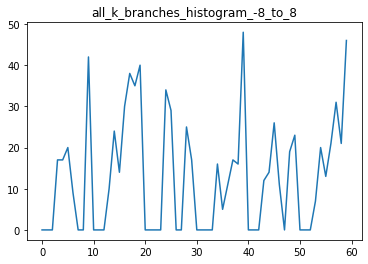

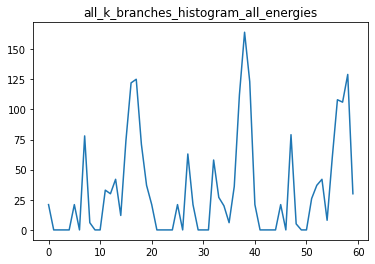

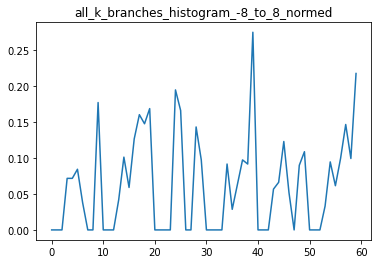

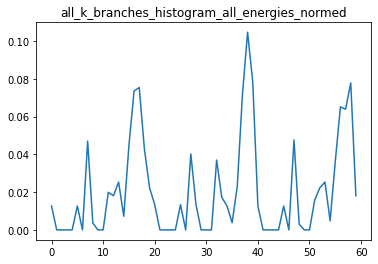

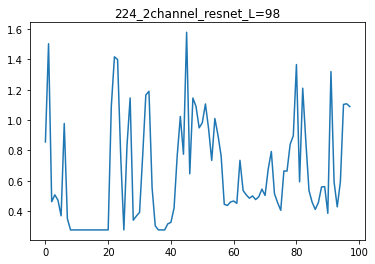

In [19]:
fingerprint_functions = {
    "all_k_branches_histogram_-8_to_8": lambda x: calc_all_k_branches_histogram_fingerprint(x, e_range=[-8, 8], normalize=False),
    "all_k_branches_histogram_all_energies": lambda x: calc_all_k_branches_histogram_fingerprint(x, normalize=False),
    "all_k_branches_histogram_-8_to_8_normed": lambda x: calc_all_k_branches_histogram_fingerprint(x, e_range=[-8, 8], normalize=True),
    "all_k_branches_histogram_all_energies_normed": lambda x: calc_all_k_branches_histogram_fingerprint(x, normalize=True),
    "224_2channel_resnet_L={0}".format(FINGERPRINT_LENGTH): lambda x: run_resnet_one_mat(x, resnet_model, resnet_input_file_type, data_directory=DATA_DIRECTORY),    
}


for fingerprint_name in fingerprint_functions: 
    fp = fingerprint_functions[fingerprint_name]("2dm-11")
    plt.plot(fp)
    plt.title(fingerprint_name)
    plt.show()
    

In [20]:
fingerprint_array = np.zeros([len(df_material), FINGERPRINT_LENGTH])

In [21]:
for i, material_id in enumerate(df_material.index):
    if i % 100 == 0:
        print(i, "/", len(df_material))

    fingerprint_array[i, :] = fingerprint_functions[FINGERPRINT_NAME](material_id)

print(fingerprint_array)

0 / 5270
100 / 5270
200 / 5270
300 / 5270
400 / 5270
500 / 5270
600 / 5270
700 / 5270
800 / 5270
900 / 5270


KeyboardInterrupt: 

In [22]:
#check for NaNs 
np.isnan(fingerprint_array).sum()
print(len(fingerprint_array))

5270


# Create T-SNE Reduced Dimension Fingerprints

In [17]:
tsne = manifold.TSNE(n_components=2, early_exaggeration=100.0, init="pca",learning_rate=100, random_state=0, perplexity=15 ,n_iter=10000, verbose=2)
fingerprint_2d = tsne.fit_transform(fingerprint_array)

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 5270 samples in 0.001s...
[t-SNE] Computed neighbors for 5270 samples in 0.765s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5270
[t-SNE] Computed conditional probabilities for sample 2000 / 5270
[t-SNE] Computed conditional probabilities for sample 3000 / 5270
[t-SNE] Computed conditional probabilities for sample 4000 / 5270
[t-SNE] Computed conditional probabilities for sample 5000 / 5270
[t-SNE] Computed conditional probabilities for sample 5270 / 5270
[t-SNE] Mean sigma: 1.088484
[t-SNE] Computed conditional probabilities in 0.120s


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 1011.3580933, gradient norm = 1.0931278 (50 iterations in 2.867s)
[t-SNE] Iteration 100: error = 1022.9692383, gradient norm = 0.9706119 (50 iterations in 3.324s)
[t-SNE] Iteration 150: error = 1025.1674805, gradient norm = 1.0014811 (50 iterations in 3.128s)
[t-SNE] Iteration 200: error = 1036.8480225, gradient norm = 0.9759018 (50 iterations in 3.924s)
[t-SNE] Iteration 250: error = 1039.4141846, gradient norm = 0.9507743 (50 iterations in 3.098s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 1039.414185
[t-SNE] Iteration 300: error = 3.4382002, gradient norm = 0.0027696 (50 iterations in 3.033s)
[t-SNE] Iteration 350: error = 2.7567773, gradient norm = 0.0013477 (50 iterations in 3.005s)
[t-SNE] Iteration 400: error = 2.4429474, gradient norm = 0.0007014 (50 iterations in 2.728s)
[t-SNE] Iteration 450: error = 2.2416446, gradient norm = 0.0005115 (50 iterations in 2.760s)
[t-SNE] Iteration 500: error = 2.1176801, gradient norm = 0.

# Quick cluster (not saved) and plots to check fingerprint and T-SNE worked

In [22]:
clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,\
                        gen_min_span_tree=False, leaf_size=40, metric='manhattan', cluster_selection_method='leaf', min_cluster_size=4, min_samples=2, p=0.2)
clusterer.fit(fingerprint_array)
labels = clusterer.labels_

Text(0.5, 1.0, 'fingerprint_length=98')

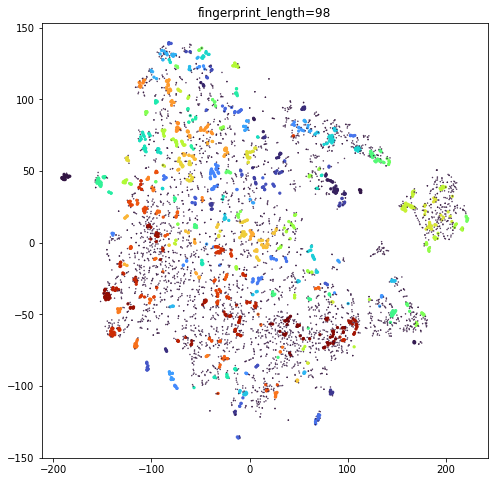

In [23]:
fig, ax  = plt.subplots(figsize=(8,8))
size=np.ones((len(labels),1))*5
size[labels==-1]=0.2

ax.scatter(fingerprint_2d[:,0], fingerprint_2d[:,1],s=size, c=labels*5, cmap="turbo")
plt.title("fingerprint_length={0}".format(FINGERPRINT_LENGTH))

# Add fingerprints, T-SNE to dataframe

In [20]:
df = df_material.join(pd.DataFrame(fingerprint_array, index=df_material.index))
df["fx"] = fingerprint_2d[:, 0]
df["fy"] = fingerprint_2d[:, 1]
df.head()

,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,binary_flatness,horz_flat_seg,exfoliation_eg,...,90,91,92,93,94,95,96,97,fx,fy
ID,,,,,,,,,,,,,,,,,,,,,
2dm-1,IrF2,AB2,164,3,0,0.095102,bottom-up,0,0,0.234620,...,1.800380,1.783413,1.751181,1.657435,1.699241,1.757099,1.648585,1.750903,80.652298,33.975147
2dm-2,Ba2Sb,AB2,164,3,1,0.387410,bottom-up,0,0,0.210650,...,2.065734,1.790841,1.797779,1.940001,1.778363,1.646309,1.777840,1.804859,-102.511086,76.040359
2dm-3,TlS,AB,2,4,4,0.846460,bottom-up,1,3,0.095794,...,2.325100,1.733577,1.816098,1.953408,1.904952,1.718350,1.920829,1.940830,-17.031164,-22.583645
2dm-4,MoCl2,AB2,166,5,4,0.713760,bottom-up,0,0,-0.055818,...,2.374648,2.153072,2.535491,1.912330,2.053569,2.283617,2.490727,2.131947,-74.647247,38.610275
2dm-6,RuI2,AB2,164,3,1,0.264930,bottom-up,0,0,0.084831,...,2.629308,2.182670,2.361369,2.758861,2.421932,2.233414,2.194449,2.162071,74.347855,47.444942


In [21]:
df.to_csv("../fingerprints/"+OUTPUT_NAME)